# K Means Clustering from scratch using Iris Dataset

Step 1 - Initialize K Centers (Randomly)

* Pick K random points from your dataset as the starting “centroids”. These represent the initial guesses for the clusters.

Step 2 - Assignment Step (E-Step)

* For each point 𝑥𝑖 :
  * Compute its distance to each centroid
  (Usually Euclidean): ∣∣𝑥𝑖 − 𝜇𝑘∣∣^ 2

  * Assign the point to the closest centroid.

  This creates K groups of points.

Step 3 - Update Step (M-Step)

* For each cluster:

  * Take all points assigned to that cluster and compute their mean: 𝜇𝑘 = (1 / ∣𝐶𝑘∣) * ∑𝑥𝑖

    where 𝑥𝑖 ∈ 𝐶𝑘
	​

  This mean becomes the new centroid.

  Why the mean? Because the mean is the point that minimizes the sum of squared distances

Step 4 — Repeat Steps 2 and 3

* Keep repeating:

   * Assign to nearest centroid

  * Recompute centroids

  Until something stabilizes:

  * Centroids barely move

  * Cluster assignments don’t change

  * Or you hit max_iterations


In [24]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score

In [25]:
iris = datasets.load_iris()
print(iris.DESCR)
X = iris.data  # (150, 4)
y_true = iris.target
feature_names = iris.feature_names

print("Iris loaded:", X.shape, "features:", feature_names)

# Standardize features (important for KMeans)
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [34]:
class KMeans:
    def __init__(self, K=5, max_iters=100, plot_steps=False, tol=1e-4, random_state=None):
        self.K = int(K)
        self.max_iters = int(max_iters)
        self.plot_steps = bool(plot_steps)
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        if random_state is not None:
            np.random.seed(random_state)

    def _init_centroids(self, X):
        N = X.shape[0]
        if self.K >= N:
            picks = np.arange(N)
            if self.K > N:
                picks = np.concatenate([picks, np.random.choice(N, self.K - N, replace=True)])
        else:
            picks = np.random.choice(N, self.K, replace=False)
        return X[picks].astype(float)

    def _closest_centroid(self, X, centroids):
        X2 = np.sum(X**2, axis=1, keepdims=True)
        C2 = np.sum(centroids**2, axis=1)
        cross = X.dot(centroids.T)
        dists = X2 + C2.reshape(1, -1) - 2*cross
        return np.argmin(dists, axis=1), dists

    def _compute_centroids(self, X, labels):
        D = X.shape[1]
        centroids = np.zeros((self.K, D), dtype=float)
        counts = np.zeros(self.K, dtype=int)
        for k in range(self.K):
            members = (labels == k)
            cnt = members.sum()
            if cnt == 0:
                centroids[k] = X[np.random.choice(X.shape[0])]
            else:
                centroids[k] = X[members].mean(axis=0)
                counts[k] = cnt
        return centroids, counts

    def fit(self, X, verbose=False):
        X = np.asarray(X, dtype=float)
        N, D = X.shape
        centroids = self._init_centroids(X) #randomly initialize the centroids
        prev_inertia = None
        do_plot = self.plot_steps and D == 2
        for i in range(1, self.max_iters + 1): #the KMeans iteration will stop till the set max_iters (centroids may or may not converge in between, depending on the variance of the data points)
            labels, distances = self._closest_centroid(X, centroids)
            sq_distances = distances[np.arange(N), labels]
            inertia = sq_distances.sum()
            if verbose:
                print(f"Iteration{i}  inertia={inertia:.6f}")
            if do_plot:
                plt.figure(figsize=(6,4))
                plt.scatter(X[:,0], X[:,1], c=labels)
                plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=100)
                plt.title(f"KMeans iteration{i}, inertia {inertia:.3f}")
                plt.xlabel("dim 0")
                plt.ylabel("dim 1")
                plt.show()
            new_centroids, counts = self._compute_centroids(X, labels)
            max_move = np.max(np.linalg.norm(new_centroids - centroids, axis=1))
            centroids = new_centroids
            if prev_inertia is not None and abs(prev_inertia - inertia) <= self.tol:
                break
            if max_move <= self.tol:
                break
            prev_inertia = inertia
        labels, distances = self._closest_centroid(X, centroids)
        sq_distances = distances[np.arange(N), labels]
        self.labels_ = labels
        self.centroids = centroids
        self.inertia_ = float(sq_distances.sum())
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        if self.centroids is None:
            raise ValueError("Model not fitted yet. Call fit(X) first.")
        labels, _ = self._closest_centroid(X, self.centroids)
        return labels

    def fit_predict(self, X, verbose=False):
        self.fit(X, verbose=verbose)
        return self.labels_

Iteration1  inertia=443.067051
Iteration2  inertia=150.110847
Iteration3  inertia=145.215230
Iteration4  inertia=142.183004
Iteration5  inertia=141.080105
Iteration6  inertia=140.901532

Final inertia (K=3): 140.90153181202442
Silhouette score (K=3): 0.4565352255831263

Contingency table (true_label -> predicted_cluster):
 True 0:  {np.int64(2): 49, np.int64(1): 1}
 True 1:  {np.int64(0): 13, np.int64(1): 37}
 True 2:  {np.int64(0): 42, np.int64(1): 8}


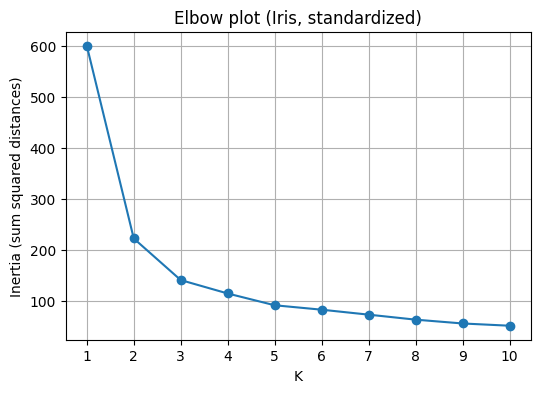

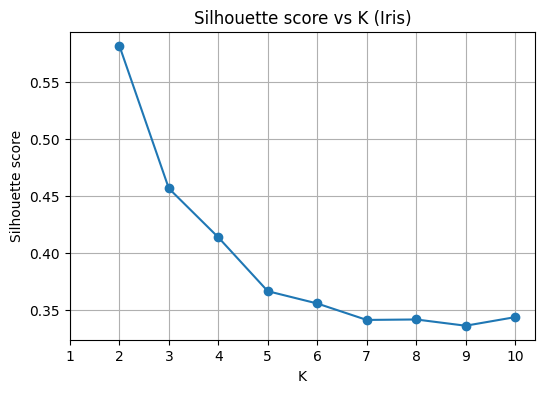

In [35]:
from collections import Counter, defaultdict

# Fit KMeans with K=3 (expected species)
model = KMeans(K=3, max_iters=200, plot_steps=False, random_state=0)
model.fit(X_scaled, verbose=True)
labels = model.labels_
print("\nFinal inertia (K=3):", model.inertia_)
sil_score = silhouette_score(X_scaled, labels)
print("Silhouette score (K=3):", sil_score)

# Compare predicted labels to true labels (simple contingency table)
contingency = defaultdict(lambda: defaultdict(int))
for t, p in zip(y_true, labels):
    contingency[t][p] += 1
print("\nContingency table (true_label -> predicted_cluster):")
for t in sorted(contingency.keys()):
    print(f" True {t}: ", dict(contingency[t]))

# Elbow plot (inertia vs K)
Ks = list(range(1, 11))
inertias = []
sil_scores = []
for k in Ks:
    m = KMeans(K=k, max_iters=200, plot_steps=False, random_state=0)
    m.fit(X_scaled)
    inertias.append(m.inertia_)
    if k > 1:
        sil_scores.append(silhouette_score(X_scaled, m.labels_))
    else:
        sil_scores.append(np.nan)

# Plot elbow
plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow plot (Iris, standardized)")
plt.xlabel("K")
plt.ylabel("Inertia (sum squared distances)")
plt.xticks(Ks)
plt.grid(True)
plt.show()

# Plot silhouette scores
plt.figure(figsize=(6,4))
plt.plot(Ks, sil_scores, marker='o')
plt.title("Silhouette score vs K (Iris)")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.xticks(Ks)
plt.grid(True)
plt.show()

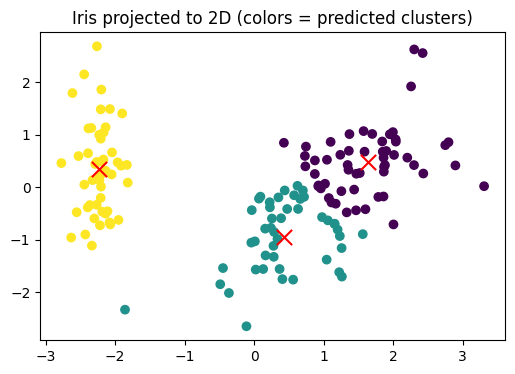

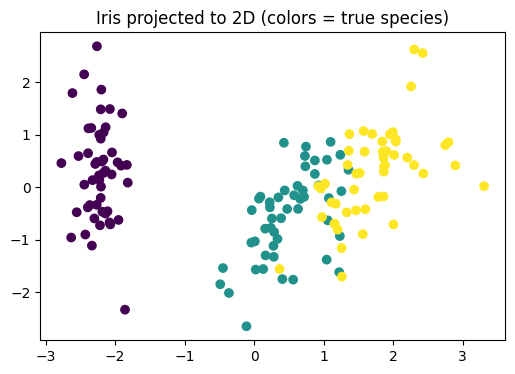

{'final_inertia_K3': 140.90153181202442, 'silhouette_K3': np.float64(0.4565352255831263), 'inertias_list': [600.0000000000001, 222.36170496502308, 140.90153181202442, 114.62604799204756, 91.55536235350215, 82.87781342945783, 73.16675804897447, 63.37059610445009, 55.88773955992633, 51.47806455111285], 'silhouette_list': [nan, np.float64(0.5817500491982808), np.float64(0.4565352255831263), np.float64(0.4136131401611601), np.float64(0.36636550489233866), np.float64(0.3555767361660205), np.float64(0.3411462290397288), np.float64(0.34154559363583215), np.float64(0.33606254785838086), np.float64(0.3435951162257151)], 'centroids_shape': (3, 4)}


In [36]:
# 2D PCA projection for visualization (color by predicted cluster and true label)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2 = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X2[:,0], X2[:,1], c=labels)
plt.scatter(model.centroids.dot(pca.components_.T)[:,0], model.centroids.dot(pca.components_.T)[:,1], color="red", marker='x', s=120)
plt.title("Iris projected to 2D (colors = predicted clusters)")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(X2[:,0], X2[:,1], c=y_true)
plt.title("Iris projected to 2D (colors = true species)")
plt.show()

# Output summary statistics dictionary for display
summary = {
    "final_inertia_K3": model.inertia_,
    "silhouette_K3": sil_score,
    "inertias_list": inertias,
    "silhouette_list": sil_scores,
    "centroids_shape": model.centroids.shape
}
print(summary)